In [1]:
import sys
import torch
from numpy import unravel_index as unravel
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np

In [2]:
action_dict = {'a': torch.tensor([0., -1.]), 'd': torch.tensor([0., 1.]), 'w': torch.tensor([-1., 0.]), 's': torch.tensor([1., 0.])}

def do(snake: torch.Tensor, action):
    reward = 0
    positions = snake.flatten().topk(2)[1]
    [pos_cur, pos_prev] = [torch.Tensor(unravel(x, snake.shape)) for x in positions]
    #print('direction', (pos_cur - pos_prev)) # Направление движения
    pos_next = (pos_cur + action) % torch.Tensor([snake.shape]).squeeze(0) 
    
    pos_cur = pos_cur.int()
    pos_next = pos_next.int()
    
    # Проверка на столкновение
    if (snake[tuple(pos_next)] > 0).any():
        reward = -100
        return reward,(snake[tuple(pos_cur)] - 2).item()  # Возвращаем счёт (длина змейки минус 2)
    
    # Кушаем яблоко
    if snake[tuple(pos_next)] == -1:
        pos_food = (snake == 0).flatten().to(torch.float).multinomial(1)[0] # Генерируем позицию яблока
        snake[unravel(pos_food, snake.shape)] = -1 # Добавляем яблоко в игру
        reward= 10
        
    else: # Двигаемся в пустую клетку
        snake[snake > 0] -= 1  # Устанавливаем все значения в теле змеи равными 1

    snake[tuple(pos_next)] = snake[tuple(pos_cur)] + 1 # перемещаем голову
    return reward, (snake[tuple(pos_cur)] - 2).item()


In [3]:
class Neuro_BigBoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(3, 32, kernel_size=(3,3), padding = 1)
        self.conv1=nn.Conv2d(32, 64, kernel_size=(3,3), padding = 1)
        self.fl = nn.Flatten()
        self.fc1=nn.Linear(64*32*32, 32)
        self.fc2=nn.Linear(32,4)

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x= F.relu(self.conv2(x))
        x = self.fl(x)
        x = F.relu(self.fc1(x))
        x = self.fc1(x)

In [4]:
class Champion():
    def __init__(self):
        super().__init__()
        self.n_games = 0
        self.model = Neuro_BigBoss().cuda()
        self.eps = 0

    def get_state(self, snake):
        head = (snake.topk(1)[0].argmax(),snake.topk(1)[1][snake.topk(1)[0].argmax()])
        up_point = head[0]-1

    def get_action(self, state):
        # random moves: tradeoff exploration / exploitation
        self.epsilon = 80 - self.n_games
        final_move = [0,0,0]
        if random.randint(0, 200) < self.epsilon:
            move = random.randint(0, 2)
            final_move[move] = 1
        else:
            state0 = torch.tensor(state, dtype=torch.float)
            prediction = self.model(state0)
            move = torch.argmax(prediction).item()
            final_move[move] = 1

        return final_move


In [10]:

snake = torch.zeros((32, 32), dtype=torch.int)
snake[0, :3] = torch.Tensor([1, 2, -1]) # [хвост, голова, яблоко]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
0 0


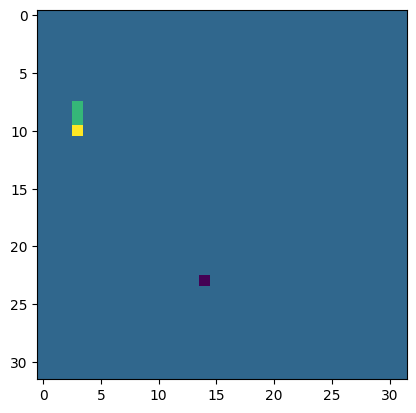

In [43]:
fig, ax = plt.subplots(1, 1)
a = torch.zeros(snake.shape)
positions = snake.flatten().topk(2)[1]
[pos_cur, pos_prev] = [torch.Tensor(unravel(x, snake.shape)) for x in positions]
a[snake>0]=1
a[snake==snake.max()]=2
a[snake<0]=-1
print(a)
img = ax.imshow(a)
action = {'val': 1}
# print(a)
n = 0
score = None
while n<1:
    img.set_data(a)
    reward, score = do(snake, action_dict['s'])
    n += 1
print(reward, score)

In [44]:
img = ax.imshow(snake)

head = [snake.topk(1)[0].argmax().numpy(),snake.topk(1)[1][snake.topk(1)[0].argmax()].numpy()]
apple = [(snake.argmin()/32).int().item(),
        (snake.argmin()%32).item()]
head[1]=head[1][0]
head_cords = (head[0].item(),head[1])
print(head_cords)
print(apple)

(11, 3)
[23, 14]


In [45]:
def a_star_algorithm(tensor, start, goal):
    def heuristic_cost_estimate(start, goal):
        return abs(start[0] - goal[0]) + abs(start[1] - goal[1])
    
    def reconstruct_path(came_from, current):
        total_path = [current]
        while current in came_from:
            current = came_from[current]
            total_path.insert(0, current)
        return total_path
    
    open_set = {start}
    cur_list = []
    came_from = {}
    g_score = {start: 0}
    f_score = {start: heuristic_cost_estimate(start, goal)}
    visited_cells = set()  # Добавление проверки посещенных ячеек
    
    while open_set:
        current = min(open_set, key=lambda x: f_score.get(x, float('inf')))
        if not (current == start):
            if current.tolist() == goal:
                return reconstruct_path(came_from, current)
        
        open_set.remove(current)
        if current in visited_cells:
            continue  # Пропуск посещенной ячейки
        # print (cur_list)
        if not (current == start):
            if current.tolist() in cur_list:
                print(5)
            cur_list.append(current)
        # print (current,goal)
        # print(visited_cells)
        
        
        visited_cells.add(current)  # Добавление посещенной ячейки
        neighbors = torch.tensor([[current[0]+1, current[1]], [current[0]-1, current[1]], 
                          [current[0], current[1]+1], [current[0], current[1]-1]])
        if neighbors[0][0]==32:
            neighbors[0][0]=0
        if neighbors[1][0]==-1:
            neighbors[1][0]=31
        if neighbors[2][1]==32:
            neighbors[2][1]=0
        if neighbors[3][1]==-1:
            neighbors[3][1]=31
        
        print(neighbors)
        
        for neighbor in neighbors:
            tentative_g_score = g_score.get(current, float('inf')) + 1
            
            tensor_list = [tuple(t) for t in tensor.tolist()]

            if tuple(neighbor.tolist()) not in tensor_list or tentative_g_score < g_score.get(neighbor, float('inf')):
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = tentative_g_score + heuristic_cost_estimate(neighbor, goal)
                if (neighbor not in open_set) and (neighbor not in visited_cells):
                    open_set.add(neighbor)
                    if current in open_set:
                        print(5)
        # print(visited_cells)
        
    return None

# Пример использования

path = a_star_algorithm(snake, head_cords, apple)
print(path)


tensor([[12,  3],
        [10,  3],
        [11,  4],
        [11,  2]])
tensor([[13,  3],
        [11,  3],
        [12,  4],
        [12,  2]])
tensor([[14,  3],
        [12,  3],
        [13,  4],
        [13,  2]])
tensor([[15,  3],
        [13,  3],
        [14,  4],
        [14,  2]])
tensor([[16,  3],
        [14,  3],
        [15,  4],
        [15,  2]])
tensor([[14,  4],
        [12,  4],
        [13,  5],
        [13,  3]])
tensor([[17,  3],
        [15,  3],
        [16,  4],
        [16,  2]])
tensor([[12,  4],
        [10,  4],
        [11,  5],
        [11,  3]])
tensor([[12,  5],
        [10,  5],
        [11,  6],
        [11,  4]])
tensor([[12,  6],
        [10,  6],
        [11,  7],
        [11,  5]])
tensor([[12,  7],
        [10,  7],
        [11,  8],
        [11,  6]])
tensor([[12,  8],
        [10,  8],
        [11,  9],
        [11,  7]])
tensor([[13,  8],
        [11,  8],
        [12,  9],
        [12,  7]])
tensor([[13,  9],
        [11,  9],
        [12, 10

In [21]:
len(path)

33

In [27]:
len(path)

30

In [41]:
len(path)

26